*Necessary imports*

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Reshape, Dense
import matplotlib.pyplot as plt
import time
starttime = time.time()
# matplotlib.use('TkAgg')

# Dummy data generation
We consider `n_sensors` sensors, each having data as a time series of sine wave with some uniform zero-mean noise added. Each sensors has a phase difference. The parameters are:

* `n_sensors`: number of sensors in the dataset; 3 for this data
*  `cycles`: How many time periods of sine wave in full data set; 300 for this data
*  `resolution`: Total number of time stamps  in `cycles` time periods; 10K for this data
* `phase`: phase difference between sensors; 9 for this data
* `PERIODICITY`: computed as $$\frac{\text{resolution}}{\text{cycles}}$$. This is also referred to as the daily offset in this demo script, since the periodicity is later used to compute the nearest neighbours in temporal bands at multiples of periodicity; (cf.`Figure 2`. in the paper)
* `NOISE`: magnitude of noise in data; default 0.2


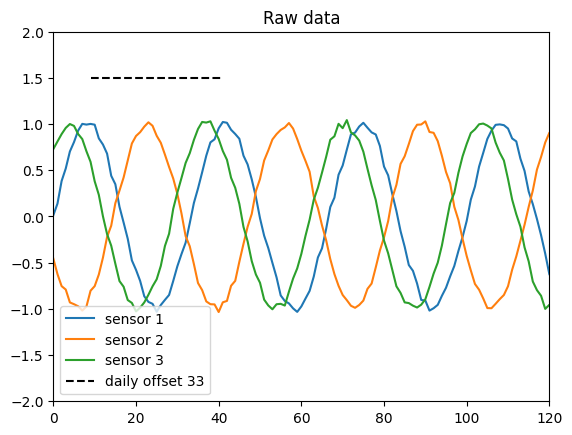

<Figure size 640x480 with 0 Axes>

In [2]:
n_sensors = 3

import os
if not os.path.exists("plots_from_demo_data"):
    os.mkdir("plots_from_demo_data")

def generate_continuous_dataset():
    """
    Generates a continuous dataset based on sine wave cycles with added noise.

    The function creates a dataset of sine waves for a specified number of cycles and resolution.
    Noise is added to simulate real-world data. The dataset is plotted and saved as an image.

    Returns:
        tuple: A tuple containing the generated dataset and the periodicity of the sine waves.
    """
    cycles = 300 # how many sine cycles
    resolution = 10000 # how many datapoints to generate
    phase = 9

    length = np.pi * 2 * cycles

    sensor_list = []
    NOISE_LEVEL = 0.1

    for i in range(n_sensors):
        values = np.sin( (np.arange(0, length, length / resolution)) - phase * i )
        shape = values.shape
        noise_with_mean_zero = (np.random.rand(*shape) - 0.5)

        sensor_list.append ( values + noise_with_mean_zero * NOISE_LEVEL )

    dataset = np.random.rand(len(sensor_list), resolution) * 0

    for counter, sensor in enumerate(sensor_list):
        dataset[counter, :] = sensor
        plt.plot(sensor, label= "sensor " + str(counter+1))

    PERIODICITY = int(resolution/cycles)
    plt.plot(range(phase, PERIODICITY + phase), [1.5] * PERIODICITY, color="black", linestyle="--", label="daily offset " + str (PERIODICITY))

    plt.legend()
    plt.ylim(-2, 2)
    plt.xlim(0, 120)
    plt.title("Raw data")
    plt.savefig("plots_from_demo_data/two_sensors_time_series.jpg", dpi=300)
    plt.show()
    plt.clf()

    return dataset, PERIODICITY
large_dataset, PERIODICITY = generate_continuous_dataset()

**Convert to supervised labels:**
The time series needs to converted to supervised labels in order to be modelled by the DL models. This is accomplished using the function `sample_blocks_for_XY`. The `i_o` value decides the number of time frames in input and ouput data. (cf. Figure 2 from the paper)


In [3]:
def dataloader(large_dataset, timestamp, i_o):
    """
    Loads a subset of data from a larger dataset.
    The dataloader should be able to access the neighbours using a timestamp index.

    Args:
        large_dataset (np.ndarray): The larger dataset from which to load data.
        i (int): The starting index for loading data.
        i_o (int): The size of the input-output blocks.

    Returns:
        tuple: A tuple containing the X and Y blocks for the specified index.

    Refer to: https://github.com/mie-lab/Complexity-Aware-Traffic-Prediction/blob/1c7c302e68276a5c8a61be7bbefca5d36b871ec6/CATP/preprocessing/ProcessRaw.py#L261C2-L261C2
    for implementation for traffic-4-cast dataset
    """
    x_i = large_dataset[:,timestamp: timestamp+i_o]
    y_i = large_dataset[:,timestamp + i_o + 1: timestamp + 2 * i_o + 1]
    return x_i, y_i

def sample_blocks_for_XY(dataset, i_o):
    """
    Converts sequential data into X,Y for time series supervised regression task
    This function ensures that there is enough room in the dataset for the input-output blocks.

    Args:
        dataset (np.ndarray): The dataset from which to sample.
        i_o (int): The size of the input-output blocks.

    Returns:
        tuple: A tuple containing arrays for X, Y, and a list of indices.
    """
    X, Y = [], []
    max_start_index = dataset.shape[1] - 2 * i_o - 1 # Ensure room for i_o at the ends of dataset
    indices_list = []
    for i in range(max_start_index):
        x_block, y_block = dataloader(dataset, timestamp=i, i_o=i_o) # dataset[:, start_index:start_index + i_o]
        X.append(x_block)
        Y.append(y_block)
        indices_list.append(i)
    return np.array(X), np.array(Y), indices_list

**Build model**
We use keras with tensorflow backend, the input and output shapes are shown for references

In [4]:
def build_model_fc(i_o):
    # Calculate the total number of elements in the input (e.g., 2*100 for a 2x100 input)
    model = Sequential([
        Flatten(input_shape=((n_sensors, i_o))),
        Dense(64, activation='relu'),
        Dense(n_sensors * i_o),  # Output layer with as many neurons as the total elements in the input
        Reshape((n_sensors, i_o))  # Reshape the output to match the input shape
    ])
    model.compile(optimizer='sgd', loss='mse')
    return model

def linf_distance(a,b):
    """
    Computes the L-infinity distance between two vectors.
    Args:
        a (np.ndarray): The first array.
        b (np.ndarray): The second array.

    Returns:
        float: The L-infinity distance between the two arrays.
    """
    return np.max(np.abs(a.flatten()-b.flatten()))

dummy_model = build_model_fc(i_o = 10)
dummy_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           1,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 3, 10)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,934 (15.37 KB)

 Trainable params: 3,934 (15.37 KB)

 Non-trainable params: 0 (0.00 B)

# Model complexity function

To make the model complexity computation efficient (and straightforward to implement), the key implementation steps are shown below:



* **Custom Dataloader**:  For each input data point, find its temporal neighbours; this is a constant time operations for time series tasks, since the dataloader can be tweaked to return the input data point at a given `timestamp`.

In [5]:

def dataloader(large_dataset, timestamp, i_o):
    """
    Loads a subset of data from a larger dataset.
    The dataloader should be able to access the neighbours using a timestamp index.

    Args:
        large_dataset (np.ndarray): The larger dataset from which to load data.
        i (int): The starting index for loading data.
        i_o (int): The size of the input-output blocks.

    Returns:
        tuple: A tuple containing the X and Y blocks for the specified index.

    Refer to: https://github.com/mie-lab/Complexity-Aware-Traffic-Prediction/blob/1c7c302e68276a5c8a61be7bbefca5d36b871ec6/CATP/preprocessing/ProcessRaw.py#L261C2-L261C2
    for implementation for traffic-4-cast dataset
    """
    x_i = large_dataset[:,timestamp: timestamp+i_o]
    y_i = large_dataset[:,timestamp + i_o + 1: timestamp + 2 * i_o + 1]
    return x_i, y_i

* **Clubbing all `model.predict` together**: To make the Model complexity ($MC$) efficient, it is recommended to compute all predictions using a dataloader since it is inefficient to call `model.predict` intermittently while doing other processing for neighbourhood search etc.. Once all predictions are ready, we can compute the model complexity by measuring the degree to which the model transforms the input space. As excerpted from the `model_complexity_MC` function below, since here our data set is small, all predictions can be stored in a list. For real datasets, (as was the case in our experiments in the paper), all predictions can be saved to disk and a similar dataloader can be used to extract the relevant predictions later on.
    ```python
    # predict for all data points so that we can process later
    predicted = [0] * N
    for i in tqdm(range(0, N, batch_size), "Predicting for all data points"):
        X = []
        for j in range(batch_size):
            x,y = dataloader(large_dataset, j, i_o=i_o)
            X.append(x)
        X = np.array(X)
        predicted[i:i+X.shape[0]] = [predicted for predicted in model_predict(X.reshape((-1, n_sensors, i_o)))]

    ```

* **Determine the neighbours**: The neighbours in temporal band of look forward and backward policy of `n_h` at multiples of periodicity are searched by:
    ```python
    for day in range(-n_d, n_d+1):
        for hour in range(-n_h, n_h+1):
            j = i + day * periodicity + hour
    ```
From Equation 4 in the paper, we had the set of neighbours for data tensor at time stamp `t` as  \mathbb{U}_t, given by:
$$
 \mathbb{U}_t = \left\{ t' \: | \: t' \neq t, \: t' =~t~\pm \underbrace{n_d \cdot 24 \cdot \frac{60}{p}}_{\text{daily periodicity offset}} \pm \underbrace{~~~n_h~~~}_{h \text{ hours look forward & backward}} \right\}
$$
Given our custom dataloader, the input data point at timestamp `j` values can be extracted in constant time as:
```python
x_j, y_j = dataloader(large_dataset, j, i_o=i_o)
```

* **Compute the maximum distance in input space**
From equations 6 and 7 in the paper, we have:
\begin{equation}
\mathbb{T}_\mathbf{x} = \{\mathbf{x_t} \: | \: t \in \mathbb{U}_t\}
\end{equation}

\begin{equation}
    r_\mathbf{x}=\text{max}(\{||\mathbf{x_i}-\mathbf{x}||_{\infty}\}\; | \mathbf{x_i} \in \mathbb{T}_\mathbf{x})
\end{equation}

In the function `model_complexity_MC`, the $r_x$ is computed using:




```
.
.   # inside the loop
    neighbour_index_list.append(j)
    x_distance_list.append(linf_distance(x_i, x_j))
max_dist_x = np.max(x_distance_list)
```



* **Sample complexity**:
For each data point, we track the predictions (output of `model.predict`, which has been pre-computed and saved in the variable `predictions`), to compute the criticality defined in Equation 8 as:
\begin{equation}
SC(\mathbf{x}|f,\mathcal{D}) = \sum_{\mathbf{x_j} \in \mathbb{T}_\mathbf{x}} \left(d_{f(\mathbf{x_j})} - r_\mathbf{x}\right) \cdot 1_{d_{f(\mathbf{x_j})}>r_\mathbf{x}}
\end{equation}
```python
        # inside loop
        compute_criticality = [0]
        for y_distance in y_distance_list:
            if y_distance > max_dist_x:
                compute_criticality.append(y_distance)
        criticality = sum(compute_criticality)
        list_of_criticality_values.append(criticality)
```

* **$MC$ as the mean over all $n$ sample complexity values**:

```python
# outside loop
return np.mean(list_of_criticality_values) # computed complexity value of the model
```
Reproducing the Equation 9 from the paper, we have:
\begin{equation}
MC(f| \mathcal{D}) = \frac{1}{N}\sum_{k=1}^{N} SC(\mathbf{x}_k|f, \mathcal{D})
\end{equation}

In [6]:

def model_complexity_MC(large_dataset,
                i_o,
                n,
                model_predict,
                periodicity,
                n_d=3,
                n_h=2,
                batch_size=32):
    """
    Computes the model complexity metric using a given DL model

    This function is similar to `model_complexity_MC` but uses the ground truth data as the prediction
    from the perfect model. It calculates the intrinsic complexity based on input-output distances.

    Args:
        large_dataset (np.ndarray): The dataset to compute the complexity on.
        i_o (int): The number of frames in input and output.
        n (int): The number of data points to consider in the complexity calculation.
        periodicity refers to the offset required for 1 day;
        n_d=3 corresponds to 1 week of neighbours (3 days look ahead and back; and the current day)
        n_h=2 corresponds to 2 hours of neighbours (1 hour look ahead and back)
        model_predict (function): The prediction function of the model
    """


    list_of_criticality_values = []

    N =  large_dataset.shape[1]

    # predict for all data points so that we can process later
    predicted = [0] * N
    for i in tqdm(range(0, N, batch_size), "Predicting for all data points"):
        X = []
        for j in range(batch_size):
            x,y = dataloader(large_dataset, j, i_o=i_o)
            X.append(x)
        X = np.array(X)

        predicted[i:i+X.shape[0]] = [predicted for predicted in model_predict(X.reshape((-1, n_sensors, i_o)))]


    for i in tqdm(range(i_o, n), "Iterating over all " + str(n) + " data points"):

        # create list of all neighbours in temporal bands
        # at multiples of periodicity
        neighbour_list = []
        x_distance_list = []
        neighbour_index_list = []
        x_i, y_i = dataloader(large_dataset, i, i_o=i_o)

        f_x_i = predicted[i]             # f(x_i)

        for day in range(-n_d, n_d+1):
            for hour in range(-n_h, n_h+1):

                j = i + day * periodicity + hour

                # ignore the tensors which are at the boundaries of the dataset
                if j + i_o < 0 or j < 0 or \
                        j >= large_dataset.shape[1] or j+i_o >= large_dataset.shape[1]:
                    continue

                if j != i:
                    x_j, y_j = dataloader(large_dataset, j, i_o=i_o)
                    assert (x_j.shape == x_i.shape)
                    neighbour_list.append(x_j)
                    neighbour_index_list.append(j)
                    x_distance_list.append(linf_distance(x_i, x_j))

        max_dist_x = np.max(x_distance_list)

        y_distance_list = []
        for neighbour_index in neighbour_index_list:
            # get f(x)
            f_x_j = predicted[neighbour_index] # model_predict(neighbour.reshape((-1,2,i_o)))
            y_distance_list.append(linf_distance(f_x_j, f_x_i))

        compute_criticality = [0]
        for y_distance in y_distance_list:
            if y_distance > max_dist_x:
                compute_criticality.append(y_distance)

        criticality = sum(compute_criticality)

        list_of_criticality_values.append(criticality)
    return np.mean(list_of_criticality_values)


* **The Intrinsic complexity ($IC$)** is implemented similarly as $MC$ with the only difference that $f_{PM} (x_j) = y_j$ instead of $f(x_j)$ = `model.predict`($x_j$). In the following function, this is marked as:         
`# THE ONLY DIFFERENCE FROM MODEL COMPLEXITY COMPUTATION`


In [7]:

def intrinsic_complexity_IC(large_dataset,
                i_o,
                n,
                model_predict,
                periodicity,
                n_d=3,
                n_h=2,
                batch_size=32):
    """
    Computes the intrinsic complexity metric using ground truth data.

    This function is similar to `model_complexity_MC` but uses the ground truth data as the prediction
    from the perfect model. It calculates the intrinsic complexity based on input-output distances.

    Args:
        large_dataset (np.ndarray): The dataset to compute the complexity on.
        i_o (int): The number of frames in input and output.
        n (int): The number of data points to consider in the complexity calculation.
        periodicity refers to the offset required for 1 day;
        n_d=3 corresponds to 1 week of neighbours (3 days look ahead and back; and the current day)
        n_h=2 corresponds to 2 hours of neighbours (1 hour look ahead and back)
        model_predict (function): The prediction function of the model
    """


    list_of_criticality_values = []

    N =  large_dataset.shape[1]

    # predict for all data points so that we can process later

    predicted = [0] * N
    for i in tqdm(range(0, N, batch_size), "Predicting for all data points"):
        X = []
        Y = []  # only differences from MC function. Here we use the ground truth as the prediction
                # from the perfect model
        for j in range(batch_size):
            x,y = dataloader(large_dataset, j, i_o=i_o)
            X.append(x)
            Y.append(y)
        X = np.array(X)


        # THE ONLY DIFFERENCE FROM MODEL COMPLEXITY COMPUTATION
        predicted[i:i+X.shape[0]] = [predicted for predicted in Y]



    for i in tqdm(range(i_o, n), "Iterating over all " + str(n) + " data points"):

        # create list of all neighbours in temporal bands
        # at multiples of periodicity
        neighbour_list = []
        x_distance_list = []
        neighbour_index_list = []
        x_i, y_i = dataloader(large_dataset, i, i_o=i_o)

        f_x_i = predicted[i]   # f(x_i)

        for day in range(-n_d, n_d+1):
            for hour in range(-n_h, n_h+1):

                j = i + day * periodicity + hour

                # ignore the tensors which are at the boundaries of the dataset
                if j + i_o < 0 or j < 0 or \
                        j >= large_dataset.shape[1] or j+i_o >= large_dataset.shape[1]:
                    continue

                if j != i:
                    x_j, y_j = dataloader(large_dataset, j, i_o=i_o)
                    assert (x_j.shape == x_i.shape)
                    neighbour_list.append(x_j)
                    neighbour_index_list.append(j)
                    x_distance_list.append(linf_distance(x_i, x_j))

        max_dist_x = np.max(x_distance_list)

        y_distance_list = []
        for neighbour_index in neighbour_index_list:
            f_x_j = predicted[neighbour_index] # model_predict(neighbour.reshape((-1,2,i_o)))
            y_distance_list.append(linf_distance(f_x_j, f_x_i))

        compute_criticality = [0]
        for y_distance in y_distance_list:
            if y_distance > max_dist_x:
                compute_criticality.append(y_distance)

        criticality = sum(compute_criticality)

        list_of_criticality_values.append(criticality)
    return np.mean(list_of_criticality_values) # computed complexity value of the model


## `Vanilla codes for plotting training and visualising predictions of time series.`

In [8]:

def plot_training_curves(model_identifer, history):
    """
    plotting the training and validation loss with time
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(loss) + 1)

    # Plotting
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, loss, 'tab:blue', label='Training loss')
    plt.plot(epochs, val_loss, 'tab:orange', label='Validation loss')
    plt.title('Training Loss' + model_identifer)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("plots_from_demo_data/training_curve_"+ model_identifer +".jpg", dpi=300)
    plt.show()
    plt.clf()

def plot_selected_predictions_val_data(val_data, i_o, model_predict, model_identifier):
    """
    plotting selected data points from the validation data to show the prediction performance
    """
    indices = [0, 50, 1400]
    ax = [0] * 3
    plt.clf()
    fig, (ax[0], ax[1], ax[2]) = plt.subplots(3)

    for counter, i in enumerate (indices):
        x,y = dataloader(val_data, timestamp=i, i_o=i_o)
        y_predict = model_predict(x.reshape((-1, n_sensors, i_o)))
        ax[counter].plot(x[0, :].flatten().tolist() + y[0, :].flatten().tolist(), label="sensor 1 GT", color="tab:blue",
                         linewidth=2)
        ax[counter].plot(x[1, :].flatten().tolist() + y[1, :].flatten().tolist(), label="sensor 2 GT", color="tab:orange",
                         linewidth=2)

        ax[counter].plot(x[0, :].flatten().tolist() + y_predict[0, 0, :].flatten().tolist(), label="sensor 1 pred", color="tab:blue",
                         linewidth=0.6)
        ax[counter].plot(x[1, :].flatten().tolist() + y_predict[0, 1, :].flatten().tolist(), label="sensor 2 pred", color="tab:orange",
                         linewidth=0.6)
        ax[counter].set_title(model_identifier)

    plt.legend(fontsize=6, loc="upper left")
    # plt.title(model_identifier)
    plt.tight_layout()
    plt.savefig("plots_from_demo_data/Predictions_" + model_identifier + ".jpg", dpi=300)
    plt.show()
    plt.clf()

Driver function ("`__main__`")

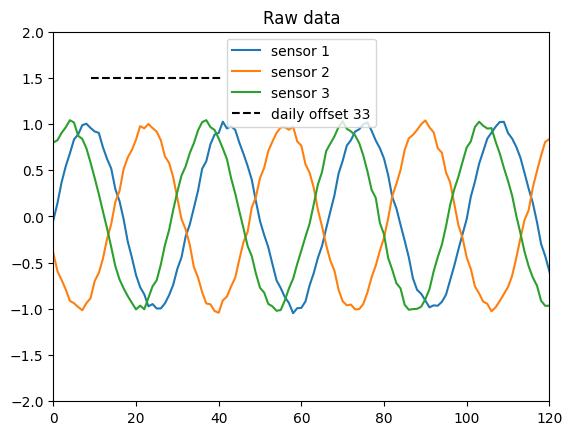

(3, 10000)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 21)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 21)                  │           1,365 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 3, 7)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,773 (10.83 KB)

 Trainable params: 2,773 (10.83 KB)

 Non-trainable params: 0 (0.00 B)

<Figure size 640x480 with 0 Axes>

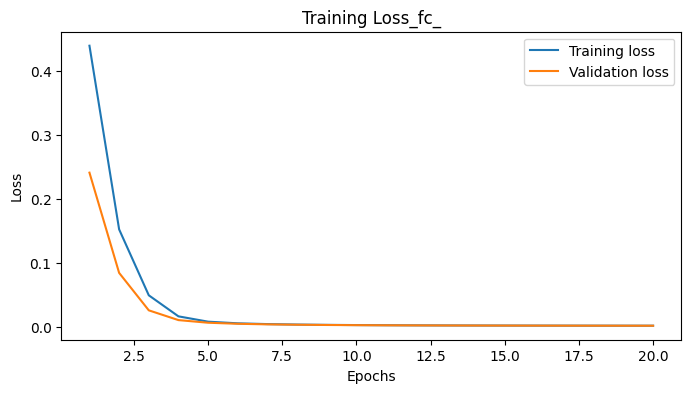

Predicting for all data points:   0%|          | 0/250 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Predicting for all data points:   0%|          | 1/250 [00:00<00:33,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:   1%|          | 3/250 [00:00<00:24, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for all data points:   2%|▏         | 4/250 [00:00<00:25,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for all data points:   2%|▏         | 6/250 [00:00<00:22, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:   3%|▎         | 8/250 [00:00<00:21, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for all data points:   4%|▍         | 10/250 [00:00<00:20, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:   5%|▍         | 12/250 [00:01<00:20, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Predicting for all data points:   6%|▌         | 14/250 [00:01<00:20, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for all data points:   6%|▋         | 16/250 [00:01<00:20, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for all data points:   7%|▋         | 18/250 [00:01<00:20, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:   8%|▊         | 20/250 [00:01<00:19, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:   9%|▉         | 22/250 [00:01<00:19, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  10%|▉         | 24/250 [00:02<00:19, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for all data points:  10%|█         | 26/250 [00:02<00:19, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  11%|█         | 28/250 [00:02<00:21, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for all data points:  12%|█▏        | 30/250 [00:02<00:21, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  13%|█▎        | 32/250 [00:02<00:20, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  14%|█▎        | 34/250 [00:03<00:19, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  14%|█▍        | 36/250 [00:03<00:19, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  15%|█▌        | 38/250 [00:03<00:20, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  16%|█▌        | 40/250 [00:03<00:19, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  17%|█▋        | 42/250 [00:03<00:18, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  18%|█▊        | 44/250 [00:03<00:17, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  18%|█▊        | 46/250 [00:04<00:17, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for all data points:  19%|█▉        | 48/250 [00:04<00:17, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  20%|██        | 50/250 [00:04<00:18, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  21%|██        | 52/250 [00:04<00:18, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for all data points:  22%|██▏       | 54/250 [00:04<00:18, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  22%|██▏       | 56/250 [00:05<00:17, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  23%|██▎       | 58/250 [00:05<00:17, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for all data points:  24%|██▍       | 60/250 [00:05<00:18, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for all data points:  25%|██▍       | 62/250 [00:05<00:18, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  26%|██▌       | 64/250 [00:05<00:17, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  26%|██▋       | 66/250 [00:06<00:16, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  27%|██▋       | 68/250 [00:06<00:16, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for all data points:  28%|██▊       | 70/250 [00:06<00:16, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  29%|██▉       | 72/250 [00:06<00:16, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  30%|██▉       | 74/250 [00:06<00:16, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  30%|███       | 76/250 [00:06<00:15, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  31%|███       | 78/250 [00:07<00:15, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  32%|███▏      | 80/250 [00:07<00:14, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for all data points:  33%|███▎      | 82/250 [00:07<00:14, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  34%|███▎      | 84/250 [00:07<00:15, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  34%|███▍      | 86/250 [00:07<00:14, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  35%|███▌      | 88/250 [00:07<00:13, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for all data points:  36%|███▌      | 90/250 [00:08<00:13, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  37%|███▋      | 92/250 [00:08<00:13, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  38%|███▊      | 94/250 [00:08<00:13, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  38%|███▊      | 96/250 [00:08<00:13, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  39%|███▉      | 98/250 [00:08<00:12, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  40%|████      | 100/250 [00:08<00:12, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  41%|████      | 102/250 [00:09<00:12, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  42%|████▏     | 104/250 [00:09<00:11, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  42%|████▏     | 106/250 [00:09<00:12, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for all data points:  43%|████▎     | 108/250 [00:09<00:12, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Predicting for all data points:  44%|████▍     | 110/250 [00:09<00:13, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for all data points:  45%|████▍     | 112/250 [00:10<00:13,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for all data points:  46%|████▌     | 114/250 [00:10<00:13,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for all data points:  46%|████▋     | 116/250 [00:10<00:14,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for all data points:  47%|████▋     | 117/250 [00:10<00:14,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for all data points:  47%|████▋     | 118/250 [00:10<00:14,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for all data points:  48%|████▊     | 119/250 [00:10<00:15,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for all data points:  48%|████▊     | 120/250 [00:11<00:14,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for all data points:  48%|████▊     | 121/250 [00:11<00:14,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Predicting for all data points:  49%|████▉     | 122/250 [00:11<00:14,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Predicting for all data points:  49%|████▉     | 123/250 [00:11<00:15,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for all data points:  50%|████▉     | 124/250 [00:11<00:15,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for all data points:  50%|█████     | 125/250 [00:11<00:15,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for all data points:  50%|█████     | 126/250 [00:11<00:16,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for all data points:  51%|█████     | 127/250 [00:11<00:16,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for all data points:  51%|█████     | 128/250 [00:12<00:15,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for all data points:  52%|█████▏    | 129/250 [00:12<00:15,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for all data points:  52%|█████▏    | 130/250 [00:12<00:14,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Predicting for all data points:  52%|█████▏    | 131/250 [00:12<00:15,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Predicting for all data points:  53%|█████▎    | 132/250 [00:12<00:15,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for all data points:  53%|█████▎    | 133/250 [00:12<00:15,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Predicting for all data points:  54%|█████▎    | 134/250 [00:12<00:15,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Predicting for all data points:  54%|█████▍    | 135/250 [00:12<00:15,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  55%|█████▍    | 137/250 [00:13<00:12,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  56%|█████▌    | 139/250 [00:13<00:11,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for all data points:  56%|█████▌    | 140/250 [00:13<00:11,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  57%|█████▋    | 142/250 [00:13<00:10, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for all data points:  58%|█████▊    | 144/250 [00:13<00:09, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  58%|█████▊    | 146/250 [00:13<00:09, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  59%|█████▉    | 148/250 [00:14<00:08, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  60%|██████    | 150/250 [00:14<00:08, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for all data points:  61%|██████    | 152/250 [00:14<00:08, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  62%|██████▏   | 154/250 [00:14<00:08, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for all data points:  62%|██████▏   | 156/250 [00:14<00:08, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  63%|██████▎   | 158/250 [00:14<00:08, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  64%|██████▍   | 160/250 [00:15<00:07, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  65%|██████▍   | 162/250 [00:15<00:07, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Predicting for all data points:  66%|██████▌   | 164/250 [00:15<00:07, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for all data points:  66%|██████▋   | 166/250 [00:15<00:07, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  67%|██████▋   | 168/250 [00:15<00:06, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  68%|██████▊   | 170/250 [00:15<00:06, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  69%|██████▉   | 172/250 [00:16<00:06, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  70%|██████▉   | 174/250 [00:16<00:06, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  70%|███████   | 176/250 [00:16<00:06, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  71%|███████   | 178/250 [00:16<00:06, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  72%|███████▏  | 180/250 [00:16<00:05, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  73%|███████▎  | 182/250 [00:16<00:05, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  74%|███████▎  | 184/250 [00:17<00:05, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for all data points:  74%|███████▍  | 186/250 [00:17<00:05, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  75%|███████▌  | 188/250 [00:17<00:05, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  76%|███████▌  | 190/250 [00:17<00:05, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  77%|███████▋  | 192/250 [00:17<00:05, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  78%|███████▊  | 194/250 [00:18<00:04, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  78%|███████▊  | 196/250 [00:18<00:04, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for all data points:  79%|███████▉  | 198/250 [00:18<00:04, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for all data points:  80%|████████  | 200/250 [00:18<00:04, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for all data points:  81%|████████  | 202/250 [00:18<00:04, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  82%|████████▏ | 204/250 [00:18<00:04, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for all data points:  82%|████████▏ | 206/250 [00:19<00:04, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  83%|████████▎ | 208/250 [00:19<00:03, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for all data points:  84%|████████▍ | 210/250 [00:19<00:03, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for all data points:  85%|████████▍ | 212/250 [00:19<00:03, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for all data points:  86%|████████▌ | 214/250 [00:19<00:03, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for all data points:  86%|████████▋ | 216/250 [00:20<00:03, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  87%|████████▋ | 218/250 [00:20<00:02, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for all data points:  88%|████████▊ | 220/250 [00:20<00:02, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  89%|████████▉ | 222/250 [00:20<00:02, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  90%|████████▉ | 224/250 [00:20<00:02, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  90%|█████████ | 226/250 [00:20<00:02, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  91%|█████████ | 228/250 [00:21<00:01, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for all data points:  92%|█████████▏| 230/250 [00:21<00:01, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  93%|█████████▎| 232/250 [00:21<00:01, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  94%|█████████▎| 234/250 [00:21<00:01, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  94%|█████████▍| 236/250 [00:21<00:01, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for all data points:  95%|█████████▌| 238/250 [00:22<00:01, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for all data points:  96%|█████████▌| 240/250 [00:22<00:00, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for all data points:  97%|█████████▋| 242/250 [00:22<00:00, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for all data points:  98%|█████████▊| 244/250 [00:22<00:00, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  98%|█████████▊| 246/250 [00:22<00:00, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for all data points:  99%|█████████▉| 248/250 [00:22<00:00, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Iterating over all 5000 data points: 100%|██████████| 4993/4993 [00:24<00:00, 201.67it/s]


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: (FC)  0.0020682337175226785
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<Figure size 640x480 with 0 Axes>

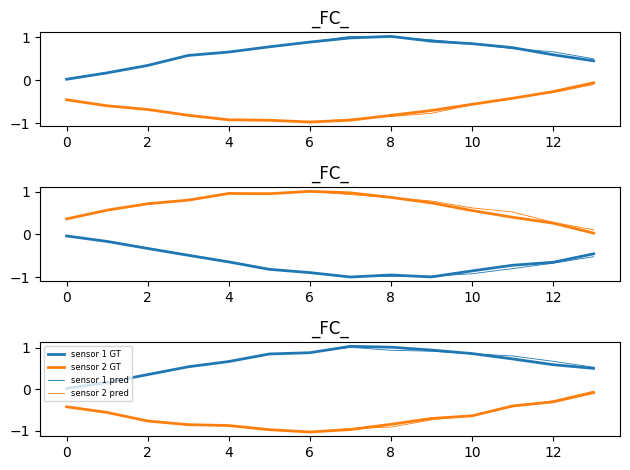

<Figure size 640x480 with 0 Axes>

In [9]:


large_dataset, PERIODICITY = generate_continuous_dataset()
print (large_dataset.shape)

i_o = 7  # Length of Input and output sequences
EPOCH = 20
n_for_complexity_calculation = 5000

TrainX, TrainY, indices_list = sample_blocks_for_XY(large_dataset[:, :-2000], i_o)
ValX, ValY,_ = sample_blocks_for_XY(large_dataset[:,-2000:], i_o)



model_fc = build_model_fc(i_o=i_o)
model_fc.summary()

history = model_fc.fit(TrainX, TrainY, epochs=EPOCH, verbose=0, validation_data=
                                        [ValX, ValY], batch_size=32)
plot_training_curves(model_identifer="_fc_", history=history)




metric_value_IC = intrinsic_complexity_IC(large_dataset[:, :8000],
                                   i_o,
                                   n_for_complexity_calculation,
                                   model_fc.predict,
                                   periodicity=PERIODICITY,
                                   n_d=2,
                                   n_h=20,
                                   batch_size=32
                                   )


# Compute the custom metric for one example
metric_value_fc = model_complexity_MC(large_dataset[:, :8000],
                                   i_o,
                                   n_for_complexity_calculation,
                                   model_fc.predict,
                                   periodicity=PERIODICITY,
                                   n_d=2,
                                   n_h=20,
                                   batch_size=32
                                   )



predicted_val_Y = model_fc.predict(ValX)
assert (predicted_val_Y.shape == ValY.shape)
print ("MSE: (FC) ",  np.mean( (ValY - predicted_val_Y) ** 2 ))

plot_selected_predictions_val_data(large_dataset[:, -2000:], i_o=i_o, model_predict=model_fc.predict, model_identifier="_FC_")


In [13]:
print("Intrinsic Complexity: ", metric_value_IC)
print("Model complexity Fully Connected: ", metric_value_fc)
print ("End-to-end Run time of script: ", round(time.time() - starttime, 2))

Intrinsic Complexity:  23.860569139086536
Model complexity Fully Connected:  20.978195152539612
End-to-end Run time of script:  265.12


# Same thing for LSTM model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 21)                  │           1,365 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 3, 7)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,957 (93.58 KB)

 Trainable params: 23,957 (93.58 KB)

 Non-trainable params: 0 (0.00 B)

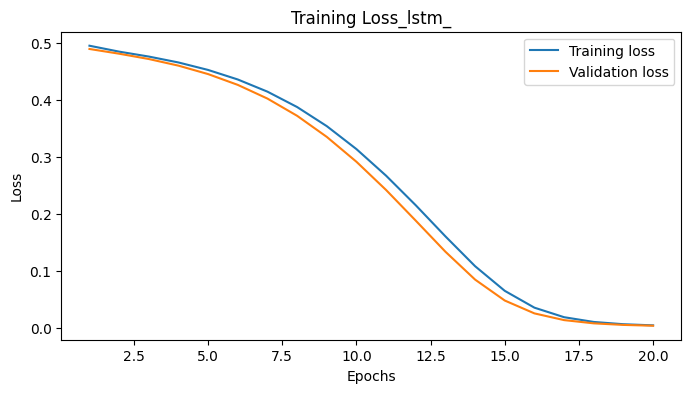

Predicting for all data points:   0%|          | 0/250 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


Predicting for all data points:   0%|          | 1/250 [00:00<01:49,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Predicting for all data points:   1%|          | 2/250 [00:00<01:04,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Predicting for all data points:   1%|          | 3/250 [00:00<00:50,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for all data points:   2%|▏         | 4/250 [00:00<00:42,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Predicting for all data points:   2%|▏         | 5/250 [00:00<00:38,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for all data points:   2%|▏         | 6/250 [00:01<00:36,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Predicting for all data points:   3%|▎         | 7/250 [00:01<00:37,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for all data points:   3%|▎         | 8/250 [00:01<00:35,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for all data points:   4%|▎         | 9/250 [00:01<00:32,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Predicting for all data points:   4%|▍         | 10/250 [00:01<00:31,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for all data points:   4%|▍         | 11/250 [00:01<00:30,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Predicting for all data points:   5%|▍         | 12/250 [00:01<00:31,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Predicting for all data points:   5%|▌         | 13/250 [00:02<00:30,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Predicting for all data points:   6%|▌         | 14/250 [00:02<00:32,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Predicting for all data points:   6%|▌         | 15/250 [00:02<00:32,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Predicting for all data points:   6%|▋         | 16/250 [00:02<00:31,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Predicting for all data points:   7%|▋         | 17/250 [00:02<00:31,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Predicting for all data points:   7%|▋         | 18/250 [00:02<00:30,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for all data points:   8%|▊         | 19/250 [00:02<00:30,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for all data points:   8%|▊         | 20/250 [00:02<00:29,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting for all data points:   8%|▊         | 21/250 [00:03<00:29,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting for all data points:   9%|▉         | 22/250 [00:03<00:31,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Predicting for all data points:   9%|▉         | 23/250 [00:03<00:30,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Predicting for all data points:  10%|▉         | 24/250 [00:03<00:31,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for all data points:  10%|█         | 25/250 [00:03<00:30,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  10%|█         | 26/250 [00:03<00:28,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  11%|█         | 28/250 [00:03<00:23,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for all data points:  12%|█▏        | 30/250 [00:04<00:22,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for all data points:  12%|█▏        | 31/250 [00:04<00:23,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for all data points:  13%|█▎        | 33/250 [00:04<00:21, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Predicting for all data points:  14%|█▍        | 35/250 [00:04<00:21, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  15%|█▍        | 37/250 [00:04<00:20, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  16%|█▌        | 39/250 [00:04<00:19, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for all data points:  16%|█▋        | 41/250 [00:05<00:20, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  17%|█▋        | 43/250 [00:05<00:20, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for all data points:  18%|█▊        | 45/250 [00:05<00:19, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  19%|█▉        | 47/250 [00:05<00:18, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  20%|█▉        | 49/250 [00:05<00:18, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  20%|██        | 51/250 [00:06<00:18, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for all data points:  21%|██        | 53/250 [00:06<00:19, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  22%|██▏       | 55/250 [00:06<00:18, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  23%|██▎       | 57/250 [00:06<00:18, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  24%|██▎       | 59/250 [00:06<00:17, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  24%|██▍       | 61/250 [00:07<00:17, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for all data points:  25%|██▌       | 63/250 [00:07<00:17, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for all data points:  26%|██▌       | 65/250 [00:07<00:18,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for all data points:  27%|██▋       | 67/250 [00:07<00:17, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  28%|██▊       | 69/250 [00:07<00:17, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  28%|██▊       | 71/250 [00:08<00:17, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for all data points:  29%|██▉       | 73/250 [00:08<00:17,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  30%|███       | 75/250 [00:08<00:17, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for all data points:  31%|███       | 77/250 [00:08<00:17, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for all data points:  32%|███▏      | 79/250 [00:08<00:16, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for all data points:  32%|███▏      | 81/250 [00:09<00:16, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for all data points:  33%|███▎      | 83/250 [00:09<00:16, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  34%|███▍      | 85/250 [00:09<00:16, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  35%|███▍      | 87/250 [00:09<00:15, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for all data points:  36%|███▌      | 89/250 [00:09<00:15, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for all data points:  36%|███▋      | 91/250 [00:09<00:14, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for all data points:  37%|███▋      | 93/250 [00:10<00:14, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  38%|███▊      | 95/250 [00:10<00:14, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  39%|███▉      | 97/250 [00:10<00:14, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  40%|███▉      | 99/250 [00:10<00:13, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for all data points:  40%|████      | 101/250 [00:10<00:13, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  41%|████      | 103/250 [00:11<00:12, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for all data points:  42%|████▏     | 105/250 [00:11<00:13, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  43%|████▎     | 107/250 [00:11<00:12, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  44%|████▎     | 109/250 [00:11<00:12, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  44%|████▍     | 111/250 [00:11<00:12, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for all data points:  45%|████▌     | 113/250 [00:11<00:12, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  46%|████▌     | 115/250 [00:12<00:12, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  47%|████▋     | 117/250 [00:12<00:12, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  48%|████▊     | 119/250 [00:12<00:12, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  48%|████▊     | 121/250 [00:12<00:11, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  49%|████▉     | 123/250 [00:12<00:11, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for all data points:  50%|█████     | 125/250 [00:13<00:11, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for all data points:  51%|█████     | 127/250 [00:13<00:11, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for all data points:  52%|█████▏    | 129/250 [00:13<00:11, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  52%|█████▏    | 131/250 [00:13<00:11, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for all data points:  53%|█████▎    | 133/250 [00:13<00:11, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for all data points:  54%|█████▍    | 135/250 [00:14<00:11,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Predicting for all data points:  54%|█████▍    | 136/250 [00:14<00:12,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Predicting for all data points:  55%|█████▍    | 137/250 [00:14<00:13,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for all data points:  55%|█████▌    | 138/250 [00:14<00:13,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for all data points:  56%|█████▌    | 139/250 [00:14<00:13,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Predicting for all data points:  56%|█████▌    | 140/250 [00:14<00:13,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for all data points:  56%|█████▋    | 141/250 [00:14<00:13,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Predicting for all data points:  57%|█████▋    | 142/250 [00:14<00:13,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for all data points:  57%|█████▋    | 143/250 [00:15<00:12,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Predicting for all data points:  58%|█████▊    | 144/250 [00:15<00:13,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for all data points:  58%|█████▊    | 145/250 [00:15<00:12,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Predicting for all data points:  58%|█████▊    | 146/250 [00:15<00:13,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Predicting for all data points:  59%|█████▉    | 147/250 [00:15<00:12,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for all data points:  59%|█████▉    | 148/250 [00:15<00:13,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for all data points:  60%|█████▉    | 149/250 [00:15<00:12,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for all data points:  60%|██████    | 150/250 [00:15<00:13,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Predicting for all data points:  60%|██████    | 151/250 [00:16<00:12,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Predicting for all data points:  61%|██████    | 152/250 [00:16<00:12,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for all data points:  61%|██████    | 153/250 [00:16<00:12,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for all data points:  62%|██████▏   | 154/250 [00:16<00:12,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for all data points:  62%|██████▏   | 155/250 [00:16<00:11,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for all data points:  62%|██████▏   | 156/250 [00:16<00:11,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for all data points:  63%|██████▎   | 157/250 [00:16<00:11,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for all data points:  63%|██████▎   | 158/250 [00:16<00:11,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for all data points:  64%|██████▎   | 159/250 [00:17<00:11,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Predicting for all data points:  64%|██████▍   | 160/250 [00:17<00:11,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for all data points:  64%|██████▍   | 161/250 [00:17<00:10,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for all data points:  65%|██████▌   | 163/250 [00:17<00:09,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for all data points:  66%|██████▌   | 165/250 [00:17<00:08, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for all data points:  67%|██████▋   | 167/250 [00:17<00:07, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  68%|██████▊   | 169/250 [00:18<00:07, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for all data points:  68%|██████▊   | 171/250 [00:18<00:07, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  69%|██████▉   | 173/250 [00:18<00:07, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for all data points:  70%|███████   | 175/250 [00:18<00:07, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for all data points:  71%|███████   | 177/250 [00:18<00:06, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  72%|███████▏  | 179/250 [00:18<00:06, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for all data points:  72%|███████▏  | 181/250 [00:19<00:06, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  73%|███████▎  | 183/250 [00:19<00:05, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for all data points:  74%|███████▍  | 185/250 [00:19<00:05, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for all data points:  75%|███████▍  | 187/250 [00:19<00:05, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  76%|███████▌  | 189/250 [00:19<00:05, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for all data points:  76%|███████▋  | 191/250 [00:20<00:05, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for all data points:  77%|███████▋  | 193/250 [00:20<00:05, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  78%|███████▊  | 195/250 [00:20<00:05, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for all data points:  79%|███████▉  | 197/250 [00:20<00:07,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for all data points:  79%|███████▉  | 198/250 [00:21<00:06,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for all data points:  80%|████████  | 200/250 [00:21<00:06,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for all data points:  81%|████████  | 202/250 [00:21<00:05,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  82%|████████▏ | 204/250 [00:21<00:04,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  82%|████████▏ | 206/250 [00:21<00:04,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for all data points:  83%|████████▎ | 208/250 [00:21<00:04,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Predicting for all data points:  84%|████████▍ | 210/250 [00:22<00:04,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for all data points:  85%|████████▍ | 212/250 [00:22<00:03,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for all data points:  85%|████████▌ | 213/250 [00:22<00:03,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  86%|████████▌ | 215/250 [00:22<00:03, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for all data points:  87%|████████▋ | 217/250 [00:22<00:03, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  88%|████████▊ | 219/250 [00:23<00:02, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for all data points:  88%|████████▊ | 221/250 [00:23<00:02, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for all data points:  89%|████████▉ | 223/250 [00:23<00:02, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for all data points:  90%|█████████ | 225/250 [00:23<00:02, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  91%|█████████ | 227/250 [00:23<00:02, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points:  92%|█████████▏| 229/250 [00:23<00:01, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for all data points:  92%|█████████▏| 231/250 [00:24<00:01, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for all data points:  93%|█████████▎| 233/250 [00:24<00:01, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for all data points:  94%|█████████▍| 235/250 [00:24<00:01, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  95%|█████████▍| 237/250 [00:24<00:01, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for all data points:  96%|█████████▌| 239/250 [00:24<00:01, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for all data points:  96%|█████████▋| 241/250 [00:25<00:00, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for all data points:  97%|█████████▋| 243/250 [00:25<00:00, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for all data points:  98%|█████████▊| 245/250 [00:25<00:00, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for all data points:  99%|█████████▉| 247/250 [00:25<00:00, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for all data points: 100%|█████████▉| 249/250 [00:25<00:00, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Iterating over all 5000 data points: 100%|██████████| 4993/4993 [00:25<00:00, 193.78it/s]


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<Figure size 640x480 with 0 Axes>

In [11]:
def build_model_lstm(i_o):
    # Calculate the total number of elements in the input (e.g., 2*100 for a 2x100 input)
    output_shape = (n_sensors, i_o)  # Adjust this to your desired output shape
    total_output_elements = np.prod(output_shape)

    model = Sequential([
        LSTM(64, input_shape=(n_sensors, i_o), return_sequences=False),
        Dense(64, activation='relu'),
        Dense(total_output_elements),  # Ensure this matches the total number of elements in the output shape
        Reshape(output_shape)  # Reshape the output to the desired shape
    ])
    model.compile(optimizer='sgd', loss='mse')
    return model

model_lstm = build_model_lstm(i_o=i_o)
model_lstm.summary()
history = model_lstm.fit(TrainX, TrainY, epochs=EPOCH, verbose=0, validation_data=
                                        [ValX, ValY], batch_size=32)
plot_training_curves(model_identifer="_lstm_", history=history)

metric_value_lstm = model_complexity_MC(large_dataset[:, :8000],
                                   i_o,
                                   5000,
                                   model_lstm.predict,
                                   periodicity=PERIODICITY,
                                   n_d=2,
                                   n_h=20,
                                   batch_size = 32
                                    )
predicted_val_Y = model_lstm.predict(ValX)
assert (predicted_val_Y.shape == ValY.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 640x480 with 0 Axes>

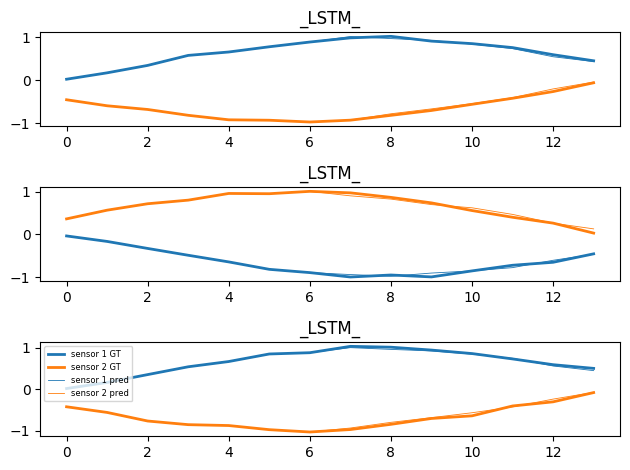

Intrinsic Complexity:  23.860569139086536
MSE: (LSTM)  0.004078882460478604
Model complexity LSTM:  16.47713051824992


<Figure size 640x480 with 0 Axes>

In [12]:
plot_selected_predictions_val_data(large_dataset[:, -2000:], i_o=i_o, model_predict=model_lstm.predict, model_identifier="_LSTM_")

print("Intrinsic Complexity: ", metric_value_IC)
print ("MSE: (LSTM) ",  np.mean( (ValY - predicted_val_Y) ** 2 ))
print("Model complexity LSTM: ", metric_value_lstm)
